In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

for i, file in enumerate(h5_files):
    with h5py.File(file, "r") as data:
        eta_hat = data["eta_hat"][:]
        phi_hat = data["phi_hat"][:]
        Hs = data["Hs"][:]
        Tp = data["Tp"][:]
        time = data["time"][:]

        modes = data.attrs["modes"]
        length = data.attrs["length"]
        Ta = data.attrs["Ta"]
        x = np.linspace(0, length, 2*modes)

    break

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

In [62]:
from tensorflow import keras
from tensorflow.keras import layers

# Branch net (takes the input function, like the sea surface snapshot)
branch_input = keras.Input(shape=(1024,))
x_branch = layers.Dense(512, activation='relu')(branch_input)
x_branch = layers.Dense(512, activation='relu')(x_branch)
branch_output = layers.Dense(1024)(x_branch) # Output dimension = 128

# Trunk net (takes the location x or (x,t))
trunk_input = keras.Input(shape=(1,))
x_trunk = layers.Dense(512, activation='relu')(trunk_input)
x_trunk = layers.Dense(512, activation='relu')(x_trunk)
trunk_output = layers.Dense(1024)(x_trunk)

# Combine branch and trunk outputs
output = layers.Multiply()([branch_output, trunk_output]) 

# Build model
model = keras.Model(inputs=[branch_input, trunk_input], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [83]:
from numpy.fft import irfft, rfft

pred_start = 1
pred_end = 10

X = irfft(eta_hat[0, :, :])

std = np.std(X)
X = X / std

X_branch = []
X_trunk = []
y = []

for i in range(X.shape[0] - pred_end):
    X_branch_local = np.tile(X[i, :], (pred_end - pred_start, 1))
    X_branch.append(X_branch_local)
    X_trunk.append(time[pred_start:pred_end])
    y.append(X[i+pred_start:i+pred_end, :])

X_branch = np.concatenate(X_branch, axis=0)
X_trunk = np.concatenate(X_trunk, axis=0).reshape(-1, 1)
y = np.concatenate(y, axis=0)

print(X_branch.shape, X_trunk.shape, y.shape)

(16119, 1024) (16119, 1) (16119, 1024)


Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.5617 - mae: 0.5809 - val_loss: 0.5864 - val_mae: 0.6068
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5626 - mae: 0.5813 - val_loss: 0.5845 - val_mae: 0.6056
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5633 - mae: 0.5813 - val_loss: 0.5854 - val_mae: 0.6060
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5599 - mae: 0.5792 - val_loss: 0.5835 - val_mae: 0.6047
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5596 - mae: 0.5789 - val_loss: 0.5848 - val_mae: 0.6054
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5620 - mae: 0.5801 - val_loss: 0.5820 - val_mae: 0.6034
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5563 - mae: 0.5764 - val_loss: 0.5835 - val_mae: 0.6045
Epoch 8/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5629 - mae: 0.5802 - val_loss: 0.5800 - val_mae: 0.6017
Epoch 9/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/

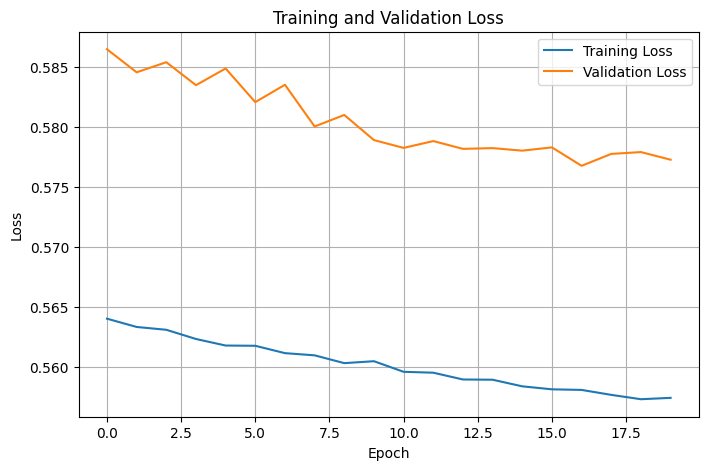

In [88]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

train_percentage = 0.9
validation_percentage = 0.1

cutoff = int(X_branch.shape[0]*train_percentage)
X_branch_train = X_branch[:cutoff, :]
X_branch_test = X_branch[cutoff:, :]

X_trunk_train = X_trunk[:cutoff, :]
X_trunk_test = X_trunk[cutoff:, :]

y_train = y[:cutoff, :]
y_test = y[cutoff:, :]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    [X_branch_train, X_trunk_train],  # Input data for branch and trunk
    y_train,                         # Target data (sea surface prediction)
    validation_split=0.1,
    batch_size=32,                   # Batch size (adjust if needed)
    epochs=50,                       # Number of epochs (adjust as needed)
    callbacks=[early_stopping],
    shuffle=True
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [89]:
y_pred = model.predict([X_branch_test, X_trunk_test])

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


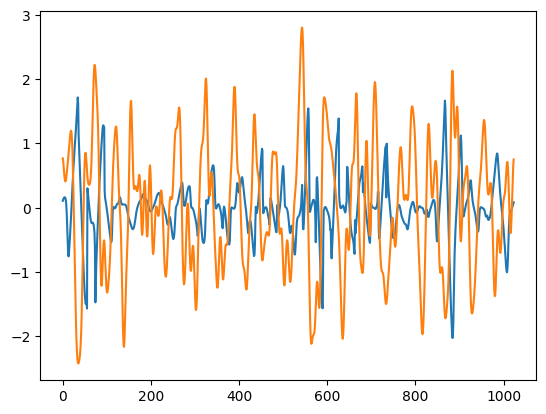

In [90]:
plt.plot(y_pred[0])
plt.plot(X_branch_test[0])